<a href="https://colab.research.google.com/github/Nganle21/Big-Data-Dreamteam/blob/main/Ngan/Trained_notebooks/Lyrics_Gen_latin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


start fr here!

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_latin.txt', 'rb').read().decode(encoding='utf-8')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

206 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

206

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 206) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (10, None, 256)           52736     
                                                                 
 gru (GRU)                   (10, None, 1024)          3938304   
                                                                 
 dense (Dense)               (10, None, 206)           211150    
                                                                 
Total params: 4,202,190
Trainable params: 4,202,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([ 55, 134,  52, 188,  71,  20, 112, 200,  49, 153, 108,  79,  74,
       143, 106,  98, 177, 118, 158, 114,  29, 128, 122, 163, 173,  53,
        20, 149, 109,  52, 117, 198, 197, 157,  60,  61,   2,  46, 103,
       148,  76, 143,  71, 120,  21,  65, 201,  48,  10,  29,  49, 182,
       187,   4, 201, 132, 203,  37,  35, 117, 187,  19,  58, 182,  55,
        82,  22,  13, 205, 160,  84, 116, 122,  67,  76,  11, 191, 141,
        69, 153,  77, 104, 106, 102, 199,   4,  67, 171,  30, 143,  30,
        13, 107,  80, 101, 179, 156,  95,  84, 148])

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
2827/2827 [==============================] - 80s 27ms/step - loss: 1.6383
Epoch 2/50
2827/2827 [==============================] - 77s 27ms/step - loss: 1.2544
Epoch 3/50
2827/2827 [==============================] - 77s 27ms/step - loss: 1.1430
Epoch 4/50
2827/2827 [==============================] - 77s 27ms/step - loss: 1.0941
Epoch 5/50
2827/2827 [==============================] - 76s 27ms/step - loss: 1.0848
Epoch 6/50
2827/2827 [==============================] - 77s 27ms/step - loss: 1.1287


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_6'

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            52736     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 206)            211150    
                                                                 
Total params: 4,202,190
Trainable params: 4,202,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"por favor",t=0.3))

por favor no pongo en el amor

es que me envientas a otro lugar
te amo y amarte a ti es contigo
si te quedas esta noche
y si te quedas entre tus brazos
y si te quedas esta preguntas que sin ti
por que te amo
y es que estoy aqu 









quiero ser tu luz
quiero continuar mi vida
que si te quedas esta noche
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu ?
y si te quedas, ¿qu


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/latin_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/latin_model.h5")

[Text(0.5, 0, 'Epochs')]

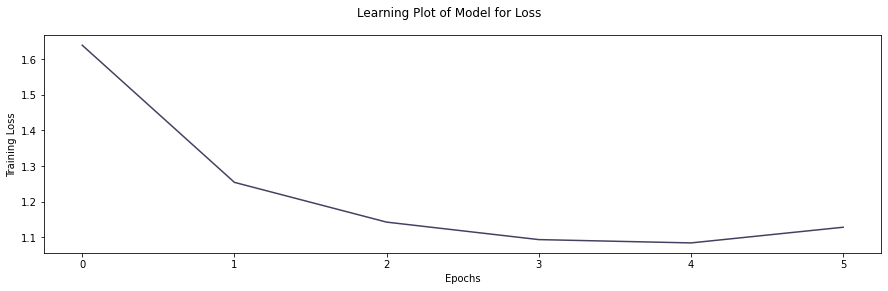

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")